## Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
# from catboost import CatBoostRegressor
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from math import log
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

## Processing functions

In [ ]:
def process(df_list, author_df):
    avgs = {}
    stds = {}
    mins = {}
    maxs = {}
    medians = {}
    for feature in author_df.columns:
        print(feature)
        if isinstance(author_df[feature].iloc[0], (int, float, np.int64, np.float64)) and not np.isnan(author_df[feature].iloc[0]):
            author_df['avg ' + feature] = author_df.groupby('author')[feature].transform('mean')
            author_df['std ' + feature] = author_df.groupby('author')[feature].transform('std')
            author_df['min ' + feature] = author_df.groupby('author')[feature].transform('min')
            author_df['max ' + feature] = author_df.groupby('author')[feature].transform('max')
            author_df['median ' + feature] = author_df.groupby('author')[feature].transform('median')
            avgs[feature] = dict(zip(author_df['author'], author_df['avg ' + feature]))
            stds[feature] = dict(zip(author_df['author'], author_df['std ' + feature]))
            mins[feature] = dict(zip(author_df['author'], author_df['min ' + feature]))
            maxs[feature] = dict(zip(author_df['author'], author_df['max ' + feature]))
            medians[feature] = dict(zip(author_df['author'], author_df['median ' + feature]))

    url_engagement = author_df[["shared_url_domain", "engagement"]]
    grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'mean'),)
    urls = dict(zip(grouped.index, grouped["engagement"]))
    author_df["url engagement"] = author_df["shared_url_domain"].map(urls)

    for df in df_list:
        for feature, avg_feature in avgs.items():
            df["avg " + feature] = df["author"].map(avg_feature)
            if feature != "engagement":
                df["dev " + feature] = np.minimum(df[feature] / df["avg " + feature], 999999)
        for feature, std_feature in stds.items():
            df["std " + feature] = df["author"].map(std_feature)
        for feature, min_feature in mins.items():
            df["min " + feature] = df["author"].map(min_feature)
        for feature, max_feature in maxs.items():
            df["max " + feature] = df["author"].map(max_feature)
        for feature, median_feature in medians.items():
            df["median " + feature] = df["author"].map(median_feature)
        df["url engagement"] = df["shared_url_domain"].map(urls)
    return df_list, author_df

def pca_process(train_df, test_df):
    V = ["V" + str(i) for i in range(1, 1025)]

    X = train_df[V]
    X_test = test_df[V]

    pca = PCA(n_components=1024)
    X_pca = pca.fit_transform(X)
    X_pca_test = pca.transform(X_test)

    pca_df = pd.DataFrame(X_pca, columns=["PC" + str(i) for i in range(1, 1025)])
    pca_df_test = pd.DataFrame(X_pca_test, columns=["PC" + str(i) for i in range(1, 1025)])

    prc_train_df = pd.concat([train_df, pca_df], axis=1)
    prc_test_df = pd.concat([test_df, pca_df_test], axis=1)

    return prc_train_df, prc_test_df

## Load

In [ ]:
author_df = pd.read_csv("authorData.csv")
train_df  = pd.read_csv("train.csv")
test_df   = pd.read_csv("test.csv")

## Process

In [ ]:
[prc_train_df, prc_test_df], prc_author_df = process([train_df, test_df], author_df)
prc_train_df, prc_test_df = pca_process(prc_train_df, prc_test_df)

engagement
timestamp
language
feature1
feature2
followers
author
word_count
shared_url_count
shared_url_domain
is_reply
is_retweet
contains_video
contains_image


In [ ]:
author_df = prc_author_df
train_df  = prc_train_df
test_df   = prc_test_df

In [ ]:
# author_df = prc_author_df[prc_author_df['engagement']<100000]
# train_df  = prc_train_df[prc_train_df['engagement']<100000]
# test_df   = prc_test_df

In [ ]:
from datetime import datetime

train_df['timestamp'] = (train_df['timestamp']/1000).apply(lambda x: datetime.fromtimestamp(x))
test_df['timestamp'] = (test_df['timestamp']/1000).apply(lambda x: datetime.fromtimestamp(x))
author_df['timestamp'] = (author_df['timestamp']/1000).apply(lambda x: datetime.fromtimestamp(x))

train_df['year'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').year)
train_df['month'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').month)
train_df['day'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').day)
train_df['hour'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').hour)
train_df['minute'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').minute)
train_df['second'] = train_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').second)

test_df['year'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').year)
test_df['month'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').month)
test_df['day'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').day)
test_df['hour'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').hour)
test_df['minute'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').minute)
test_df['second'] = test_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').second)

author_df['year'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').year)
author_df['month'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').month)
author_df['day'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').day)
author_df['hour'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').hour)
author_df['minute'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').minute)
author_df['second'] = author_df['timestamp'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S.%f').second)

train_df['word_count_60'] = train_df['word_count'].apply(lambda x: 1 if x<60 else 0)
test_df['word_count_60'] = test_df['word_count'].apply(lambda x: 1 if x<60 else 0)
author_df['word_count_60'] = author_df['word_count'].apply(lambda x: 1 if x<60 else 0)

temp_df = pd.concat([author_df,train_df.iloc[:, 0:13]])

Average_author_engagement = temp_df.groupby('author')['engagement'].mean()
Std_author_engagement = temp_df.groupby('author')['engagement'].std()
Median_author_engagement = temp_df.groupby('author')['engagement'].median()
Min_author_engagement = temp_df.groupby('author')['engagement'].min()
Max_author_engagement = temp_df.groupby('author')['engagement'].max()

Average_author_word_count = temp_df.groupby('author')['word_count'].mean()
Std_author_word_count = temp_df.groupby('author')['word_count'].std()
Median_author_word_count = temp_df.groupby('author')['word_count'].median()
Min_author_word_count = temp_df.groupby('author')['word_count'].min()
Max_author_word_count = temp_df.groupby('author')['word_count'].max()

Average_number_followers = temp_df['followers'].mean()
Std_number_followers = temp_df['followers'].std()
Median_number_followers = temp_df['followers'].median()
Min_number_followers = temp_df['followers'].min()
Max_number_followers = temp_df['followers'].max()

Average_Word_count_mean_engagement = temp_df.groupby('word_count')['engagement'].mean()
Std_Word_count_mean_engagement = temp_df.groupby('word_count')['engagement'].std()
Median_Word_count_mean_engagement = temp_df.groupby('word_count')['engagement'].median()
Min_Word_count_mean_engagement = temp_df.groupby('word_count')['engagement'].min()
Max_Word_count_mean_engagement = temp_df.groupby('word_count')['engagement'].max()

train_df['Average_Word_count_mean_engagement'] = train_df['word_count'].apply(lambda x: Average_Word_count_mean_engagement[x])
test_df['Average_Word_count_mean_engagement'] = test_df['word_count'].apply(lambda x: Average_Word_count_mean_engagement[x] if x in Average_Word_count_mean_engagement.index else np.nan)
author_df['Average_Word_count_mean_engagement'] = author_df['word_count'].apply(lambda x: Average_Word_count_mean_engagement[x] if x in Average_Word_count_mean_engagement.index else np.nan)

train_df['Std_Word_count_mean_engagement'] = train_df['word_count'].apply(lambda x: Std_Word_count_mean_engagement[x])
test_df['Std_Word_count_mean_engagement'] = test_df['word_count'].apply(lambda x: Std_Word_count_mean_engagement[x] if x in Std_Word_count_mean_engagement.index else np.nan)
author_df['Std_Word_count_mean_engagement'] = author_df['word_count'].apply(lambda x: Std_Word_count_mean_engagement[x] if x in Std_Word_count_mean_engagement.index else np.nan)

train_df['Median_Word_count_mean_engagement'] = train_df['word_count'].apply(lambda x: Median_Word_count_mean_engagement[x])
test_df['Median_Word_count_mean_engagement'] = test_df['word_count'].apply(lambda x: Median_Word_count_mean_engagement[x] if x in Median_Word_count_mean_engagement.index else np.nan)
author_df['Median_Word_count_mean_engagement'] = author_df['word_count'].apply(lambda x: Median_Word_count_mean_engagement[x] if x in Median_Word_count_mean_engagement.index else np.nan)

train_df['Min_Word_count_mean_engagement'] = train_df['word_count'].apply(lambda x: Min_Word_count_mean_engagement[x])
test_df['Min_Word_count_mean_engagement'] = test_df['word_count'].apply(lambda x: Min_Word_count_mean_engagement[x] if x in Min_Word_count_mean_engagement.index else np.nan)
author_df['Min_Word_count_mean_engagement'] = author_df['word_count'].apply(lambda x: Min_Word_count_mean_engagement[x] if x in Min_Word_count_mean_engagement.index else np.nan)

train_df['Max_Word_count_mean_engagement'] = train_df['word_count'].apply(lambda x: Max_Word_count_mean_engagement[x])
test_df['Max_Word_count_mean_engagement'] = test_df['word_count'].apply(lambda x: Max_Word_count_mean_engagement[x] if x in Max_Word_count_mean_engagement.index else np.nan)
author_df['Max_Word_count_mean_engagement'] = author_df['word_count'].apply(lambda x: Max_Word_count_mean_engagement[x] if x in Max_Word_count_mean_engagement.index else np.nan)

train_df['Average_author_engagement'] = train_df['author'].apply(lambda x: Average_author_engagement[x])
test_df['Average_author_engagement'] = test_df['author'].apply(lambda x: Average_author_engagement[x] if x in Average_author_engagement.index else np.nan)
author_df['Average_author_engagement'] = author_df['author'].apply(lambda x: Average_author_engagement[x] if x in Average_author_engagement.index else np.nan)

train_df['Std_author_engagement'] = train_df['author'].apply(lambda x: Std_author_engagement[x])
test_df['Std_author_engagement'] = test_df['author'].apply(lambda x: Std_author_engagement[x] if x in Std_author_engagement.index else np.nan)
author_df['Std_author_engagement'] = author_df['author'].apply(lambda x: Std_author_engagement[x] if x in Std_author_engagement.index else np.nan)

train_df['Median_author_engagement'] = train_df['author'].apply(lambda x: Median_author_engagement[x])
test_df['Median_author_engagement'] = test_df['author'].apply(lambda x: Median_author_engagement[x] if x in Median_author_engagement.index else np.nan)
author_df['Median_author_engagement'] = author_df['author'].apply(lambda x: Median_author_engagement[x] if x in Median_author_engagement.index else np.nan)

train_df['Min_author_engagement'] = train_df['author'].apply(lambda x: Min_author_engagement[x])
test_df['Min_author_engagement'] = test_df['author'].apply(lambda x: Min_author_engagement[x] if x in Min_author_engagement.index else np.nan)
author_df['Min_author_engagement'] = author_df['author'].apply(lambda x: Min_author_engagement[x] if x in Min_author_engagement.index else np.nan)

train_df['Max_author_engagement'] = train_df['author'].apply(lambda x: Max_author_engagement[x])
test_df['Max_author_engagement'] = test_df['author'].apply(lambda x: Max_author_engagement[x] if x in Max_author_engagement.index else np.nan)
author_df['Max_author_engagement'] = author_df['author'].apply(lambda x: Max_author_engagement[x] if x in Max_author_engagement.index else np.nan)

train_df['Average_author_word_count'] = train_df['author'].apply(lambda x: Average_author_word_count[x])
test_df['Average_author_word_count'] = test_df['author'].apply(lambda x: Average_author_word_count[x] if x in Average_author_word_count.index else np.nan)
author_df['Average_author_word_count'] = author_df['author'].apply(lambda x: Average_author_word_count[x] if x in Average_author_word_count.index else np.nan)

train_df['Std_author_word_count'] = train_df['author'].apply(lambda x: Std_author_word_count[x])
test_df['Std_author_word_count'] = test_df['author'].apply(lambda x: Std_author_word_count[x] if x in Std_author_word_count.index else np.nan)
author_df['Std_author_word_count'] = author_df['author'].apply(lambda x: Std_author_word_count[x] if x in Std_author_word_count.index else np.nan)

train_df['Median_author_word_count'] = train_df['author'].apply(lambda x: Median_author_word_count[x])
test_df['Median_author_word_count'] = test_df['author'].apply(lambda x: Median_author_word_count[x] if x in Median_author_word_count.index else np.nan)
author_df['Median_author_word_count'] = author_df['author'].apply(lambda x: Median_author_word_count[x] if x in Median_author_word_count.index else np.nan)

train_df['Min_author_word_count'] = train_df['author'].apply(lambda x: Min_author_word_count[x])
test_df['Min_author_word_count'] = test_df['author'].apply(lambda x: Min_author_word_count[x] if x in Min_author_word_count.index else np.nan)
author_df['Min_author_word_count'] = author_df['author'].apply(lambda x: Min_author_word_count[x] if x in Min_author_word_count.index else np.nan)

train_df['Max_author_word_count'] = train_df['author'].apply(lambda x: Max_author_word_count[x])
test_df['Max_author_word_count'] = test_df['author'].apply(lambda x: Max_author_word_count[x] if x in Max_author_word_count.index else np.nan)
author_df['Max_author_word_count'] = author_df['author'].apply(lambda x: Max_author_word_count[x] if x in Max_author_word_count.index else np.nan)

train_df['log_followers'] = train_df['followers'].apply(lambda x: log(1+x))
test_df['log_followers'] = test_df['followers'].apply(lambda x: log(1+x))
author_df['log_followers'] = author_df['followers'].apply(lambda x: log(1+x))

# train_df = train_df.drop(columns=['timestamp','avg timestamp'])
# test_df = test_df.drop(columns=['timestamp','avg timestamp'])
# author_df = author_df.drop(columns=['timestamp','avg timestamp'])

In [ ]:
for i in range(1,1025):
  train_df = train_df.drop(columns=f'V{i}')
  test_df = test_df.drop(columns=f'V{i}')

for i in range(1,1025):
  train_df = train_df.drop(columns=f'PC{i}')
  test_df = test_df.drop(columns=f'PC{i}')

## Imports

In [ ]:
url_engagement = temp_df[["shared_url_domain", "engagement"]].dropna()
grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'mean'),)

train_df['mean_url_discrepancy'] = train_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
test_df['mean_url_discrepancy'] = test_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
author_df['mean_url_discrepancy'] = author_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)

grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'median'),)

train_df['median_url_discrepancy'] = train_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
test_df['median_url_discrepancy'] = test_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
author_df['median_url_discrepancy'] = author_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)

grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'min'),)

train_df['min_url_discrepancy'] = train_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
test_df['min_url_discrepancy'] = test_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
author_df['min_url_discrepancy'] = author_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)

grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'max'),)

train_df['max_url_discrepancy'] = train_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
test_df['max_url_discrepancy'] = test_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
author_df['max_url_discrepancy'] = author_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)

grouped = url_engagement.groupby("shared_url_domain").agg(engagement=('engagement', 'std'),)

train_df['std_url_discrepancy'] = train_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
test_df['std_url_discrepancy'] = test_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)
author_df['std_url_discrepancy'] = author_df['shared_url_domain'].apply(lambda x: float(grouped.loc[x].values) if x in grouped.index else np.nan)

In [ ]:
# N = 1023
# PCs1 = ["PC" + str(i) for i in range(1, N+1)]
# PCs2 = ['PC1011','PC25','PC641','PC40','PC308','PC3','PC5','PC825','PC287','PC933','PC406','PC882','PC643','PC788','PC622','PC381']

# for PC in PCs1:
#   if PC not in PCs2:
#     train_df = train_df.drop(columns=PC)
#     test_df = test_df.drop(columns=PC)

In [ ]:
correlation_matrix = pd.concat([author_df,train_df]).corr()['engagement']
correlation_matrix.abs().sort_values(ascending=False)

engagement                        1.000000
mean_url_discrepancy              0.793380
url engagement                    0.792797
median_url_discrepancy            0.781447
min_url_discrepancy               0.746639
                                    ...   
Max_Word_count_mean_engagement    0.001055
minute                            0.000260
Min_Word_count_mean_engagement    0.000102
std shared_url_count                   NaN
year                                   NaN
Name: engagement, Length: 80, dtype: float64

In [ ]:
features = list(correlation_matrix.abs()[correlation_matrix.abs()>0.1].index)[1:]
features

['followers',
 'avg engagement',
 'std engagement',
 'min engagement',
 'max engagement',
 'median engagement',
 'avg followers',
 'std followers',
 'min followers',
 'max followers',
 'median followers',
 'url engagement',
 'Average_author_engagement',
 'Std_author_engagement',
 'Median_author_engagement',
 'Min_author_engagement',
 'Max_author_engagement',
 'log_followers',
 'mean_url_discrepancy',
 'median_url_discrepancy',
 'min_url_discrepancy',
 'max_url_discrepancy',
 'std_url_discrepancy']

In [ ]:
# features = [
#     'day',
#     'hour',
#     'log_followers',
#     "avg engagement",
#     # 'author',
#     # "timestamp",
#     # "feature1",
#     # "feature2",
#     # "word_count",
#     "followers",
#     # "is_reply",
#     # "is_retweet",
#     "contains_video",
#     # "contains_image",
#     # "shared_url_count",
#     # "url engagement",

# ] # + PCs

# avgs = [
#     # # "avg engagement",
#     # # "avg timestamp",
#     # "avg feature1",
#     # "avg feature2",
#     # # "avg followers",
#     # "avg word_count",
#     # # "avg shared_url_count",
# ]

# devs = [
#     # # "dev timestamp",
#     # "dev feature1",
#     # "dev feature2",
#     # # "dev followers",
#     # "dev word_count",
# ]

# Separate features and target variable
X = pd.concat([train_df[features],author_df[features]])
y = pd.concat([train_df,author_df])['engagement']

In [ ]:
# regressor = xgb.XGBRegressor(
#     task_type="GPU",
#     objective='reg:squarederror',  # Specify regression as the learning task
#     n_estimators=90,  # Number of boosting rounds
#     learning_rate=0.02,  # Step size shrinkage used to prevent overfitting
#     max_depth=2,  # Maximum depth of the tree
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
#     random_state=100,  # Random seed for reproducibility
#     verbose=1,
#     reg_lambda=2,
#     enable_categorical=True
# )
# regressor.fit(X, y)
# train_predictions = regressor.predict(X)
# # Calculate and print R2 scores
# r2_train = r2_score(y, train_predictions)
# print(f'R2 Train : {r2_train*100:.2f}%')

In [ ]:
# pd.concat([author_df,train_df.iloc[:, 0:13],test_df])

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

# Assuming X is your feature matrix with NaN values
# Create KNNImputer instance
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed

# Impute NaN values using KNN
X_train_imputed = knn_imputer.fit_transform(X)
X_test_imputed = knn_imputer.transform(test_df[features])
X_train_imputed

In [ ]:
np.savetxt('X_train_imputed', X_train_imputed)
np.savetxt('X_test_imputed', X_test_imputed)

In [ ]:
# Import necessary libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_train_imputed)
y = y.astype('float32')
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 0.5
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Output layer for regression

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss=rmse, metrics=['mae'])

# Print a summary of the model architecture
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6144      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# regressor = xgb.XGBRegressor(
#     task_type="GPU",
#     objective='reg:squarederror',  # Specify regression as the learning task
#     n_estimators=1400,  # Number of boosting rounds
#     learning_rate=0.035,  # Step size shrinkage used to prevent overfitting
#     max_depth=2,  # Maximum depth of the tree
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.83,  # Subsample ratio of columns when constructing each tree
#     random_state=100,  # Random seed for reproducibility
#     verbose=1,
#     reg_lambda=2,
#     enable_categorical=True
# )
# regressor.fit(X_train, y_train)

# # Make predictions on the training and test data
# train_predictions = regressor.predict(X_train)
# train_predictions = [max(element,0) for element in train_predictions]

# test_predictions = regressor.predict(X_test)
# test_predictions = [max(element,0) for element in test_predictions]

# # Calculate and print R2 scores
# r2_train = r2_score(y_train, train_predictions)
# r2_test = r2_score(y_test, test_predictions)

# print(f'R2 Train : {r2_train*100:.2f}%')
# print(f'R2 Test  : {r2_test*100:.2f}%')

In [ ]:
# train_df["prediction"] = regressor.predict(X)

# train_df["SE"] = (train_df["engagement"] - train_df["prediction"]) ** 2
# train_df["E"]  = train_df["prediction"] - train_df["engagement"]
# # Get feature importances
# feature_importances = regressor.feature_importances_
# # Create a DataFrame to store feature names and their importances
# feature_importance_df = pd.DataFrame({'Feature': X.columns,'Importance': feature_importances})
# # Sort the DataFrame by importance in descending order
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# # Print feature importances
# print('\nFeature Importances:')
# print(feature_importance_df)

In [ ]:
# predictions = regressor.predict(test_df[features])
# predictions = [max(element,0) for element in predictions]
# final_submission = pd.DataFrame({'Id': test_df['Id'], "engagement":predictions})
# final_submission['Id'] = final_submission['Id'].astype('int')

In [ ]:
predictions = model.predict(scaler.transform(X_test_imputed))
predictions = [max(element,0) for element in predictions]
final_submission = pd.DataFrame({'Id': test_df['Id'], "engagement":predictions})
final_submission['Id'] = final_submission['Id'].astype('int')
final_submission['engagement'] = final_submission['engagement'].astype('int')

59/59 [==============================] - 0s 1ms/step


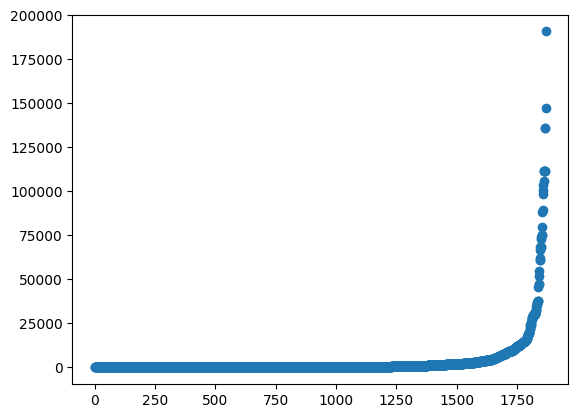

In [ ]:
plt.scatter(list(range(1871)),final_submission['engagement'].sort_values().values)

In [ ]:
from google.colab import files
final_submission.to_csv('Benjamin Cohen - M2 Proba-Finance 2023.csv',header=['Id',"engagement"],index=False)
files.download('Benjamin Cohen - M2 Proba-Finance 2023.csv')

In [ ]:
final_submission

,Id,engagement
0,1,77
1,2,632
2,3,2819
3,4,2820
4,5,18
...,...,...
1866,2493,778
1867,2495,42
1868,2496,98
1869,2498,177


(array([1.799e+03, 4.000e+01, 5.000e+00, 1.100e+01, 3.000e+00, 9.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([     0. ,  19072.6,  38145.2,  57217.8,  76290.4,  95363. ,
        114435.6, 133508.2, 152580.8, 171653.4, 190726. ]),
 <BarContainer object of 10 artists>)

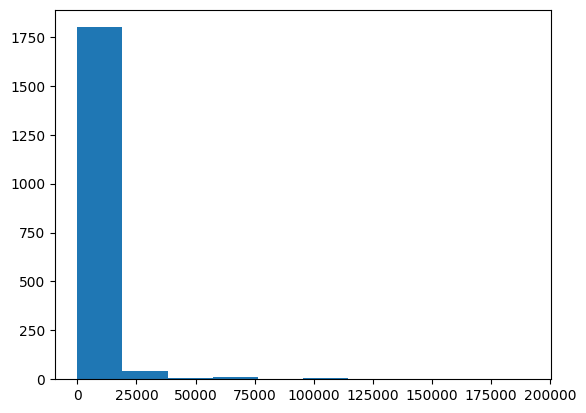

In [ ]:
plt.hist(final_submission['engagement'])

In [ ]:
# from google.colab import files
# final_submission.to_csv('Essai.csv',header=['Id',"engagement"],index=False)
# files.download('Essai.csv')